In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

#Statistics
# Statistics
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle

# READ CSV AND DESCRIPTION OF SERIES


In [2]:
#ACTIVE ADDRESSES
active_addresses = pd.read_csv("data/bitcoin-number-of-active-addresses.csv")

active_addresses["Active Addresses/t"] = active_addresses["Active Addresses/t"].str.rstrip("T00:00:00.000Z")
active_addresses["Active Addresses/t"] = pd.to_datetime(active_addresses["Active Addresses/t"])
active_addresses = active_addresses.sort_values(by='Active Addresses/t')
active_addresses = active_addresses.rename(columns={'Active Addresses/t': 'Timestamp', 'Active Addresses/v': 'Value'})

#Description
print(active_addresses.head())
print("\nShape is:", active_addresses.shape)
print("\nSummary of the dataset:")
active_addresses.describe()
print("\nAre there null values?")
active_addresses.isna().sum()

   Timestamp  Value
0 2008-12-29      0
1 2009-01-05      0
2 2009-01-12     34
3 2009-01-19     63
4 2009-01-26     61

Shape is: (713, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Value        0
dtype: int64

In [10]:
ann = []
for el in [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]:
    ann.append(active_addresses['Timestamp'][active_addresses['Timestamp'].dt.year == el].shape[0])
ann

[52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52]

In [9]:
# I remove the only two dates which are not every 7 days but refer to a day after one of the days
active_addresses = active_addresses.drop(index = [161,500]).reset_index()

In [38]:
aa_short = active_addresses.loc[(active_addresses['Timestamp'].dt.year>2010)&(active_addresses['Timestamp'].dt.year<2022),:].reset_index()

# VISUALIZATION

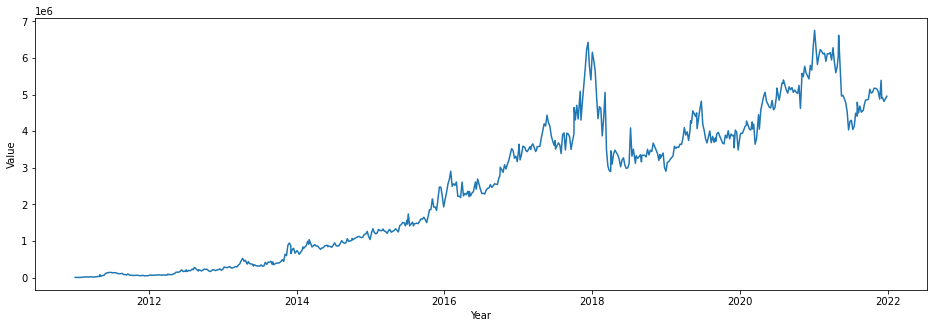

In [39]:
plt.figure(figsize=(16,5))
plt.plot(aa_short["Timestamp"], aa_short["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

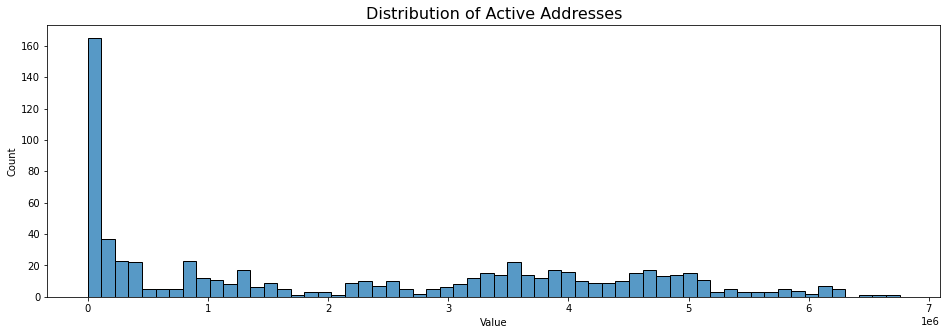

In [12]:
plt.figure(figsize=(16,5))
sns.histplot(active_addresses["Value"], kde = False, bins = 60)
plt.title('Distribution of Active Addresses', fontsize=16)
plt.show()

## Sesonal analysis

We use STL and compare robust = True and False

In [40]:
res1 = STL(aa_short["Value"], period = 52, robust = True).fit()
res2 = STL(aa_short["Value"], period = 52).fit()

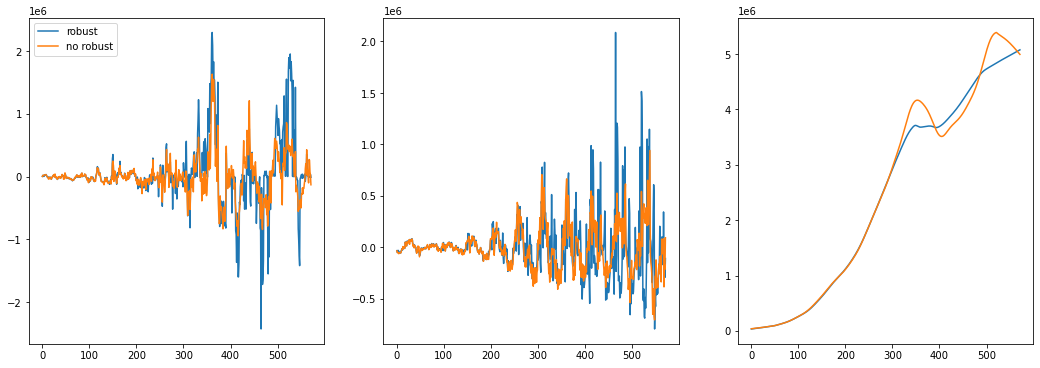

In [41]:
fig, axs = plt.subplots(ncols=3, figsize=(18,6))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)

Since we see that the plot with the logarithmic scale is quite regular (below) we repeat the decomposition analysis after log-transforming the time series

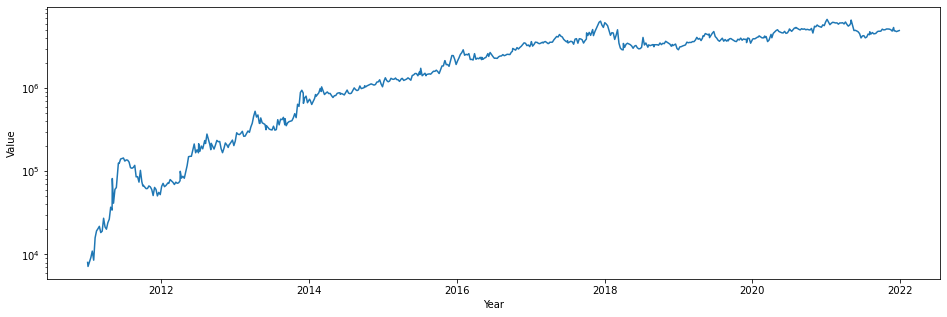

In [42]:
plt.figure(figsize=(16,5))
plt.plot(aa_short["Timestamp"], aa_short["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
plt.yscale('log') 
plt.show()

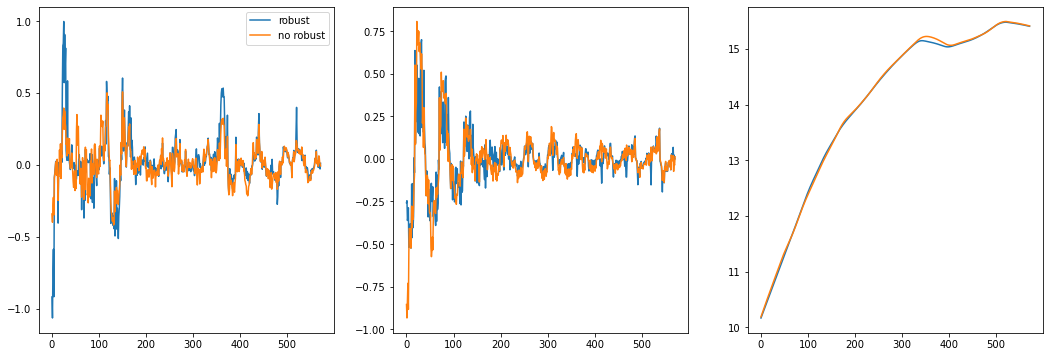

In [43]:
res3 = STL(np.log(aa_short["Value"]), period = 52, robust = True).fit()
res4 = STL(np.log(aa_short["Value"]), period = 52).fit()
fig, axs = plt.subplots(ncols=3, figsize=(18,6))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)

In this case the not robust one seems better beacuse residuals are more homoscedastic. We now try to interpolate the given trend with an exponential curve $y=a*exp(b*x)+c$. We expect $b$ and $a$ to be negative. we put bounds to the parameters otherwise the algorithm does not work.

In [67]:
def func(x, a, b, c):
    return -a * np.exp(-b * x) + c
popt, _ = curve_fit(func, np.arange(572), res4.trend, bounds = (0,20))
popt

array([5.81319534e+00, 5.83655644e-03, 1.57381026e+01])

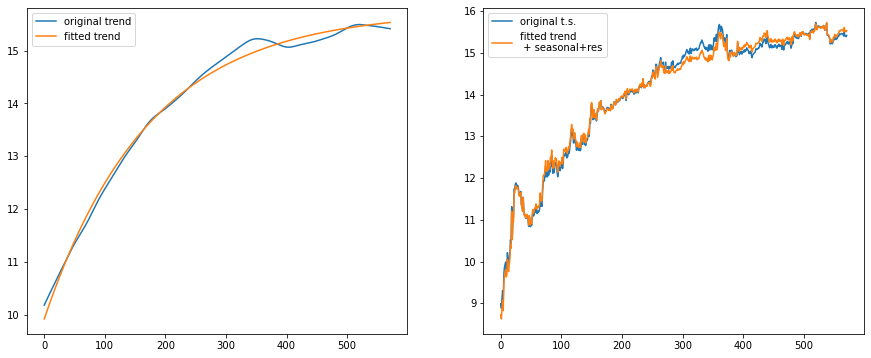

In [75]:
fitted = pd.Series(func(np.arange(572), *popt), index = aa_short.index)
fig, axs = plt.subplots(ncols=2, figsize=(15,6))
axs[0].plot(res4.trend, label="original trend")
axs[0].plot(fitted, label="fitted trend")
axs[0].legend()
axs[1].plot(np.log(aa_short["Value"]), label='original t.s.')
#axs[1].plot(fitted_season, label='fitted trend\n + seasonal')
axs[1].plot(fitted+res4.seasonal+res4.resid, label='fitted trend\n + seasonal+res')
axs[1].legend()